# MELODIST 5min precipitation example

In this notebook the usage of MELODIST for working with highly resolved precipitation utilizing the cascade model is demonstrated.
For this purpose, we use a subset of the station data for Rosenthal-Willershausen, which is located in the file `examples/testdata_precip5min.csv.gz`. The approach differs to some degree from the examples involving hourly data. The reason for that is the design of the station which is (up to now) limited to hourly data and its statistics. Here we call functions of the MELODIST package directly.

Import all relevant packages:

In [2]:
import pandas as pd
import numpy as np
import melodist
import matplotlib.pyplot as plt

%matplotlib inline 

First, we load time series data which includes 7 years of highly resolved rainfall data (i.e. 5 minutes temporal resolution):

In [3]:
file = 'testdata_precip5min.csv.gz'
data = pd.read_csv(file, names=['time','precip'], parse_dates=[0], \
                   index_col=0)


Before we start running MELODIST features, a first look at the data reveals some interesting things to keep in mind. We briefly explore the data in terms of unique values:

In [6]:
np.unique(data['precip'])

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
        2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
        4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  6.4,  6.8,  7.2,  8.2,
       10.2, 10.8, 13.2])

This table reveals that the time series consist of multiples of 0.2 mm/5min. This is a technical limitation of the rain gauge used here. It is a tipping bucket rain gauge which needs to collect at least 0.2 mm of water (in fact, it's a personal weather station of one of the authors; for this purpose the accuracy is sufficient ;-) ). This value is the minimum value required to send a signal to the data logger. Hence, a continuous series is seprated into 0.2 mm volumes or multiples of the value. This limitation in accuracy has some implications for modelling. Since a lot of smaller events below this threshold are not captured, a single value of 0.2 mm/5min might cover several small events. What about the distribution of values?

In [9]:
median = np.percentile(data['precip'][data['precip']>0.],50)
p90    = np.percentile(data['precip'][data['precip']>0.],90)
print(median)
print(p90)

0.2
0.4


Since the median is equal to the minimum value, using the median for separating below and above average conditions is not feasible. Only the 90 percent value does not coincide with the minimum value. Therefore, we utilize the 90 percent value to perform statistics for below and above average conditions, respectively. 

Please note: The following line is subjected to higher computation time (up to one minute):

In [10]:
cascopt = melodist.build_casc(data,hourly=False,level=9, percentile=90)

n.b.: Running with the median will result in warnings.

Once the statistics have been derived, you can run the disaggregation function accordingly. Please note that an independent period is often used (split-sample test). Due to the limited length of the time series, we apply the same period for both calibration and disaggregation. However, we involve four different realisations to highlight the stochastic nature of the methodology:

In [12]:
# derive daily values first
precip_daily = data.resample('D').sum()

n = 4
list_res = list()
for ii in range(n):
    disag = melodist.disagg_prec_cascade(precip_daily['precip'],cascopt[0], \
                                         hourly=False,level=9)
    list_res.append(disag)

For displaying the results we define a function that allows displaying both intensities and cumulative series. As an example we focus on 04 Sep 2011. Please feel free to change the date.

In [13]:
def plot(cumsum=False):
    plt.figure(figsize=(9,9))
    for ii in range(n):
        disag = list_res[ii]
        results = pd.DataFrame(data={'Observed':data['precip'], 'Disaggregated':disag})
        ax = plt.subplot(2, 2, ii+1)
        if cumsum:
            np.cumsum(results['20110904']).plot(ax=ax)
        else:
            results['20110904'].plot(ax=ax)
        if ii > 1:
            ax.set_xlabel('Time')
        else:
            ax.set_xlabel('')
        if ii == 0 or ii == 2:
            ax.set_ylabel('Rainfall intensity [mm/5min]')
        ax.set_title('Realisation #%i' % (ii+1))
    plt.tight_layout()

Now we can run the function twice in order to visualize intensities and the mass curves:

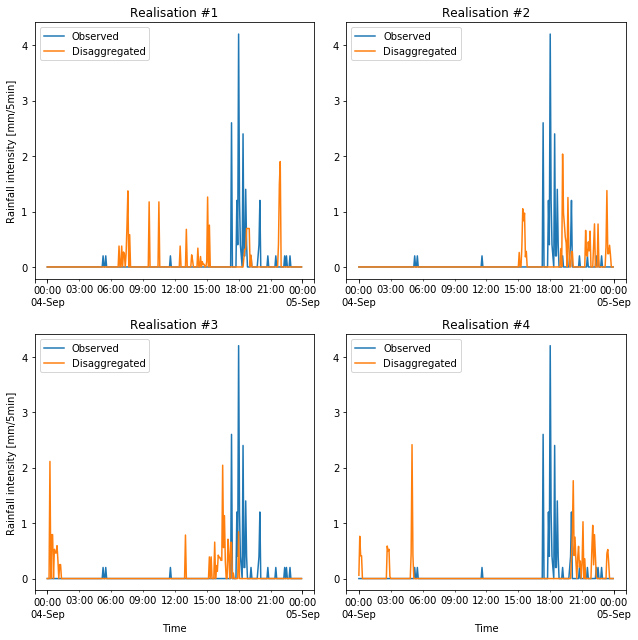

In [14]:
plot(cumsum=False)

This plot demonstrates that completely different solutions are possible on that day. However, major characteristics of the multi-year period should be preserved. In order to show that the model preserves the precipitation total on each day, we run the same function using `cumsum=True`:

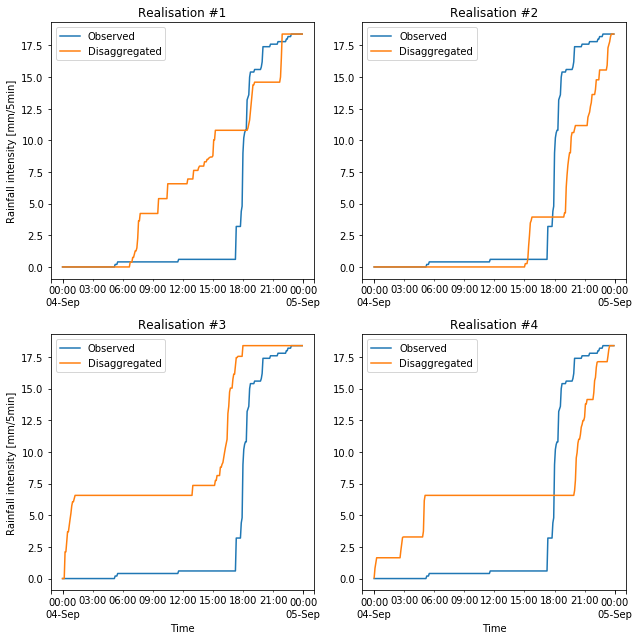

In [15]:
plot(cumsum=True)

In each panel both mass curves show the same value on 05 Sept 00 at 00:00.